# GhostWriter Evaluation



## Functions

In [ ]:
from typing import Callable

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from luminar.utils.evaluation import run_evaluation
from luminar.baselines.binoculars import GLOBAL_BINOCULARS_THRESHOLD


def get_settings_from_model_name(model_name: str):
    match model_name.split("-"):
        case ["binoculars", *_]:
            threshold = GLOBAL_BINOCULARS_THRESHOLD
            sigmoid = False
            less_than = True
        case [("radar" | "e5_lora"), *_]:
            threshold = 0.5
            sigmoid = False
            less_than = False
        case [("fast_detectgpt" | "detectllm_llr"), *_]:
            threshold = 0.5
            sigmoid = True
            less_than = False
        case _:
            raise RuntimeError(f"Unknown model {model_name}")

    return threshold, sigmoid, less_than


def binarize_fusion_as_ai(df: pd.DataFrame) -> pd.DataFrame:
    df["label"] = (df["label"] > 0).astype(int)
    return df


def binarize_drop_fusion(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["label"] < 2]


def run_ghostwriter_eval(
    dataframes: dict[str, dict[str, pd.DataFrame]],
    binarize_fusion: Callable[[pd.DataFrame], pd.DataFrame],
) -> pd.DataFrame:
    results = []
    for model_name, subsets in tqdm(dataframes.items(), desc="Evaluating"):
        threshold, sigmoid, less_than = get_settings_from_model_name(model_name)

        for corpus, df in subsets.items():
            df = binarize_fusion(df.copy())

            agents = set(df["agent"].unique())
            if "human" in agents:
                agents.remove("human")

            if not agents:
                agents = ("human",)

            for agent in agents:
                df_agent = df[(df["agent"] == "human") | (df["agent"] == agent)]

                labels = df_agent["label"]
                y_scores = df_agent["y_score"]
                y_preds = df_agent["y_pred"] if "y_pred" in df_agent.columns else None

                results.append(
                    {
                        "model": model_name,
                        "corpus": corpus,
                        "agent": agent,
                        "domain": "all",
                    }
                    | run_evaluation(
                        np.array(labels),
                        np.array(y_scores),
                        threshold=threshold,
                        sigmoid=sigmoid,
                        less_than=less_than,
                        y_preds=np.array(y_preds) if y_preds is not None else None,
                    )
                )

            for domain in df["domain"].unique():
                df_domain = df[(df["domain"] == domain)]

                labels = df_domain["label"]
                y_scores = df_domain["y_score"]
                y_preds = df_domain["y_pred"] if "y_pred" in df_domain.columns else None

                results.append(
                    {
                        "model": model_name,
                        "corpus": corpus,
                        "agent": "all",
                        "domain": domain,
                    }
                    | run_evaluation(
                        np.array(labels),
                        np.array(y_scores),
                        threshold=threshold,
                        sigmoid=sigmoid,
                        less_than=less_than,
                        y_preds=np.array(y_preds) if y_preds is not None else None,
                    )
                )

    return pd.DataFrame.from_records(results)

In [55]:
def postprocess_df_domain(_df: pd.DataFrame) -> pd.DataFrame:
    _df = (
        _df.copy().set_index("domain")
        .sort_index()
        .rename(
            index={
                "arxiv_papers": "arXiv",
                "blog_authorship_corpus": "Blogs",
                "bundestag": "Bundestag",
                "cnn_news": "CNN",
                "euro_court_cases": "ECHR",
                "gutenberg": "Gutenberg",
                "house_of_commons": "HoC",
                "spiegel_articles": "Spiegel",
                "student_essays": "Essays",
            },
        )
        .drop(columns=["model"])
    )
    _df.loc["Overall"] = _df.mean(numeric_only=True)
    return _df


def postprocess_df_agent(_df: pd.DataFrame) -> pd.DataFrame:
    _df = (
        _df.copy().set_index("agent")
        .sort_index()
        .rename(
            index={
                "arxiv_papers": "arXiv",
                "blog_authorship_corpus": "Blogs",
                "bundestag": "Bundestag",
                "cnn_news": "CNN",
                "euro_court_cases": "ECHR",
                "gutenberg": "Gutenberg",
                "house_of_commons": "HoC",
                "spiegel_articles": "Spiegel",
                "student_essays": "Essays",
            },
        )
        .drop(columns=["model"])
    )
    _df.loc["Overall"] = _df.mean(numeric_only=True)
    return _df

In [3]:
def get_figure_df(
    df_subset: pd.DataFrame, pivot: str, model: str, threshold_method: str = ""
) -> pd.DataFrame:
    _df = df_subset[df_subset["model"] == model].copy()
    _df["f1_macro"] = (
        _df[f"f1_human{threshold_method}"] + _df[f"f1_ai{threshold_method}"]
    ) / 2
    return _df[
        [
            "model",
            pivot,
            "f1_macro",
            f"roc_auc{threshold_method}",
            f"tpr{threshold_method}",
            f"fpr{threshold_method}",
        ]
    ]


def get_figure_df_agent(
    df_subset: pd.DataFrame, model: str, threshold_method: str = ""
) -> pd.DataFrame:
    return get_figure_df(df_subset, "agent", model, threshold_method)


def get_figure_df_domain(
    df_subset: pd.DataFrame, model: str, threshold_method: str = ""
) -> pd.DataFrame:
    return get_figure_df(df_subset, "domain", model, threshold_method)


## Load Data

In [4]:
from collections import defaultdict
from pathlib import Path


preds_path = Path("/storage/projects/stoeckel/GhostWriter/predictions")

dataframes = defaultdict(dict)
for preds_model_path in preds_path.iterdir():
    for corpus_path in preds_model_path.glob("*.csv"):
        df = pd.read_csv(corpus_path, index_col=0).dropna(subset=["y_score", "label"])
        dataframes[preds_model_path.stem][corpus_path.stem] = df

## With Fusion as AI

In [5]:
df = run_ghostwriter_eval(dataframes, binarize_fusion=binarize_fusion_as_ai)
df

Models:   0%|          | 0/8 [00:00<?, ?model/s]

,model,corpus,agent,domain,n_samples,f1_score,precision,recall,accuracy,roc_auc,...,roc_auc_fpr,fpr_fpr,tpr_fpr,tnr_fpr,fnr_fpr,f1_human_fpr,f1_ai_fpr,threshold_fpr,n_samples_human,n_samples_ai
0,fast_detectgpt-gpt-neo-2,test,gpt-4-turbo,all,29984,0.050777,0.992564,0.032184,0.032184,0.700892,...,0.700892,0.050406,0.177419,0.949594,0.822581,0.971587,0.038350,0.999430,29798,186
1,fast_detectgpt-gpt-neo-2,test,nemotron,all,30718,0.050928,0.861619,0.052119,0.052119,0.461031,...,0.461031,0.050406,0.056522,0.949594,0.943478,0.959805,0.042037,0.999430,29798,920
2,fast_detectgpt-gpt-neo-2,test,phi3:3.8b,all,32399,0.054833,0.481860,0.082009,0.082009,0.206724,...,0.206724,0.050406,0.011918,0.949594,0.988082,0.932876,0.014998,0.999430,29798,2601
3,fast_detectgpt-gpt-neo-2,test,o3-mini,all,30272,0.050658,0.958776,0.040731,0.040731,0.543350,...,0.543350,0.050406,0.048523,0.949594,0.951477,0.966641,0.023012,0.999430,29798,474
4,fast_detectgpt-gpt-neo-2,test,deepseek-r1:32b,all,30431,0.050816,0.975889,0.046334,0.046334,0.676082,...,0.676082,0.050406,0.120063,0.949594,0.879937,0.964894,0.068747,0.999430,29798,633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,detectllm_llr-falcon-7b,test,all,bundestag,13117,0.597423,0.512572,0.715941,0.715941,0.784194,...,0.784194,0.049651,0.489937,0.950349,0.510063,0.587377,0.649079,0.883393,3726,9391
132,detectllm_llr-falcon-7b,test,all,student_essays,29044,0.588311,0.502720,0.709028,0.709028,0.748440,...,0.748440,0.050172,0.424173,0.949828,0.575827,0.566558,0.587187,0.904400,8451,20593
133,detectllm_llr-falcon-7b,test,all,euro_court_cases,7435,0.648253,0.568518,0.754001,0.754001,0.583724,...,0.583724,0.049754,0.151088,0.950246,0.848912,0.417487,0.258863,0.908579,1829,5606
134,detectllm_llr-falcon-7b,test,all,cnn_news,12362,0.569668,0.482734,0.694790,0.694790,0.726131,...,0.726131,0.050093,0.436838,0.949907,0.563162,0.587830,0.598883,0.903587,3773,8589


In [6]:
# %%script echo "Skipping"

df.to_csv(preds_path / "GhostWriter_test-baselines-fusion_as_ai.csv", index=False)
df.to_csv(
    Path("/resources/public/stoeckel/PrismAI")
    / "GhostWriter_test-baselines-fusion_as_ai.csv",
    index=False,
)

In [7]:
df_subset_agent = df[(df["agent"] != "all")].copy()
df_subset_domain = df[(df["domain"] != "all")].copy()

### By Domain

In [8]:
threshold_method = "_mean"

# df_fdg_j6B_neo27 = get_figure_df_domain(df_subset_domain, "fast_detectgpt-gpt-j-6B_gpt-neo-2", threshold_method)
# df_fdg_falcon_7b = get_figure_df_domain(df_subset_domain, "fast_detectgpt-falcon-7b", threshold_method)

df_dllm = get_figure_df_domain(
    df_subset_domain,
    "detectllm_llr-falcon-7b",
    threshold_method,
)
df_fdg = get_figure_df_domain(
    df_subset_domain,
    "fast_detectgpt-falcon-7b_falcon-7b-instruct",
    threshold_method,
)
df_binoculars = get_figure_df_domain(
    df_subset_domain,
    "binoculars-falcon-7b",
    threshold_method,
)

df_figure_likelihood = pd.concat(
    map(
        postprocess_df_domain,
        [df_dllm, df_fdg, df_binoculars],
    ),
    axis=1,
)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean \\
domain &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.587 & 0.727 & 0.586 & 0.225 & 0.623 & 0.767 & 0.671 & 0.292 & 0.616 & 0.768 & 0.557 & 0.047 \\
Blogs & 0.555 & 0.614 & 0.598 & 0.464 & 0.570 & 0.636 & 0.567 & 0.383 & 0.573 & 0.642 & 0.597 & 0.418 \\
Bundestag & 0.672 & 0.784 & 0.637 & 0.181 & 0.704 & 0.814 & 0.731 & 0.262 & 0.700 & 0.811 & 0.657 & 0.140 \\
CNN & 0.646 & 0.726 & 0.626 & 0.257 & 0.714 & 0.824 & 0.759 & 0.297 & 0.736 & 0.824 & 0.649 & 0.043 \\
ECHR & 0.522 & 0.584 & 0.571 & 0.457 & 0.637 & 0.755 & 0.735 & 0.416 & 0.630 & 0.759 & 0.601 & 0.186 \\
Gutenberg & 0.636 & 0.803 & 0.717 & 0.247 & 0.707 & 0.875 & 0.815 & 0.264 & 0.701 & 0.877 & 0.727 & 0.031 \\
HoC & 0.590 & 0.680 & 0.618 & 0.355 & 0.692 & 0.811 & 0.728 & 0.266 & 0.683 & 0.811 & 0.615 & 0.066 \\
Spiegel & 0.596 & 0

In [9]:
df_radar = get_figure_df_domain(df_subset_domain, "radar")
df_e5_lora = get_figure_df_domain(df_subset_domain, "e5_lora")

df_figure_pretrained = pd.concat(
    map(postprocess_df_domain, [df_radar, df_e5_lora]), axis=1
)
print(df_figure_pretrained.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrrrrr}
\toprule
 & f1_macro & roc_auc & tpr & fpr & f1_macro & roc_auc & tpr & fpr \\
domain &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.262 & 0.693 & 0.087 & 0.004 & 0.552 & 0.752 & 0.907 & 0.809 \\
Blogs & 0.505 & 0.504 & 0.591 & 0.571 & 0.621 & 0.703 & 0.811 & 0.578 \\
Bundestag & 0.259 & 0.452 & 0.044 & 0.052 & 0.440 & 0.406 & 0.794 & 0.886 \\
CNN & 0.489 & 0.848 & 0.280 & 0.019 & 0.629 & 0.838 & 0.921 & 0.679 \\
ECHR & 0.605 & 0.699 & 0.622 & 0.306 & 0.454 & 0.745 & 0.983 & 0.971 \\
Gutenberg & 0.323 & 0.701 & 0.215 & 0.084 & 0.687 & 0.859 & 0.748 & 0.149 \\
HoC & 0.532 & 0.695 & 0.443 & 0.188 & 0.715 & 0.842 & 0.815 & 0.360 \\
Spiegel & 0.209 & 0.641 & 0.019 & 0.007 & 0.410 & 0.588 & 0.293 & 0.200 \\
Essays & 0.564 & 0.755 & 0.438 & 0.123 & 0.572 & 0.758 & 0.966 & 0.807 \\
Overall & 0.416 & 0.665 & 0.304 & 0.150 & 0.564 & 0.721 & 0.804 & 0.604 \\
\bottomrule
\end{tabular}



### By Agent

In [10]:
# df_fdg_j6B_neo27 = get_figure_df_agent(df_subset_agent, "fast_detectgpt-gpt-j-6B_gpt-neo-2", threshold_method)
# df_fdg_falcon_7b = get_figure_df_agent(df_subset_agent, "fast_detectgpt-falcon-7b", threshold_method)

df_dllm = get_figure_df_agent(
    df_subset_agent,
    "detectllm_llr-falcon-7b",
    threshold_method,
)
df_fdg = get_figure_df_agent(
    df_subset_agent,
    "fast_detectgpt-falcon-7b_falcon-7b-instruct",
    threshold_method,
)
df_binoculars = get_figure_df_agent(
    df_subset_agent,
    "binoculars-falcon-7b",
    threshold_method,
)

df_figure_likelihood = pd.concat(
    map(
        postprocess_df_agent,
        [df_dllm, df_fdg, df_binoculars],
    ),
    axis=1,
)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean \\
agent &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
deepseek-r1:1.5b & 0.291 & 0.341 & 0.384 & 0.616 & 0.420 & 0.692 & 0.647 & 0.391 & 0.447 & 0.688 & 0.610 & 0.329 \\
deepseek-r1:32b & 0.389 & 0.641 & 0.615 & 0.431 & 0.445 & 0.786 & 0.712 & 0.322 & 0.514 & 0.782 & 0.610 & 0.171 \\
gemma2:9b & 0.588 & 0.642 & 0.610 & 0.432 & 0.701 & 0.790 & 0.726 & 0.321 & 0.716 & 0.787 & 0.636 & 0.176 \\
gpt-4-turbo & 0.385 & 0.698 & 0.677 & 0.399 & 0.429 & 0.824 & 0.780 & 0.296 & 0.490 & 0.822 & 0.667 & 0.139 \\
gpt-4o-mini & 0.669 & 0.747 & 0.666 & 0.327 & 0.775 & 0.869 & 0.809 & 0.260 & 0.809 & 0.867 & 0.688 & 0.052 \\
nemotron & 0.298 & 0.394 & 0.482 & 0.615 & 0.424 & 0.697 & 0.652 & 0.387 & 0.467 & 0.705 & 0.639 & 0.296 \\
o3-mini & 0.325 & 0.465 & 0.506 & 0.545 & 0.393 & 0.667 & 0.639 & 0.409 & 0.408 & 0.662 

In [11]:
df_radar = get_figure_df_agent(df_subset_agent, "radar")
df_e5_lora = get_figure_df_agent(df_subset_agent, "e5_lora")

df_figure_pretrained = pd.concat(
    map(postprocess_df_agent, [df_radar, df_e5_lora]), axis=1
)
print(df_figure_pretrained.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrrrrr}
\toprule
 & f1_macro & roc_auc & tpr & fpr & f1_macro & roc_auc & tpr & fpr \\
agent &  &  &  &  &  &  &  &  \\
\midrule
deepseek-r1:1.5b & 0.539 & 0.761 & 0.581 & 0.159 & 0.288 & 0.749 & 0.869 & 0.663 \\
deepseek-r1:32b & 0.486 & 0.597 & 0.284 & 0.159 & 0.276 & 0.687 & 0.828 & 0.663 \\
gemma2:9b & 0.481 & 0.580 & 0.254 & 0.159 & 0.551 & 0.646 & 0.782 & 0.663 \\
gpt-4-turbo & 0.466 & 0.580 & 0.274 & 0.159 & 0.258 & 0.634 & 0.731 & 0.663 \\
gpt-4o-mini & 0.575 & 0.658 & 0.370 & 0.159 & 0.567 & 0.725 & 0.838 & 0.663 \\
nemotron & 0.528 & 0.736 & 0.497 & 0.159 & 0.287 & 0.635 & 0.839 & 0.663 \\
o3-mini & 0.475 & 0.578 & 0.238 & 0.159 & 0.269 & 0.649 & 0.793 & 0.663 \\
phi3:3.8b & 0.542 & 0.586 & 0.312 & 0.159 & 0.335 & 0.636 & 0.809 & 0.663 \\
Overall & 0.512 & 0.634 & 0.351 & 0.159 & 0.354 & 0.670 & 0.811 & 0.663 \\
\bottomrule
\end{tabular}



## Misc


### Thresholds

In [ ]:
df_stats = df_subset_domain[["model", "threshold_mean"]]
df_stats = df_stats[
    (df_stats["model"] == "binoculars-falcon-7b")
    | (df_stats["model"] == "fast_detectgpt-falcon-7b_falcon-7b-instruct")
]
df_stats.groupby(["model"]).agg(
    threshold_mean_avg=("threshold_mean", "mean"),
    threshold_mean_std=("threshold_mean", "std"),
    threshold_mean_min=("threshold_mean", "min"),
    threshold_mean_max=("threshold_mean", "max"),
).reset_index()

,model,threshold_mean_avg,threshold_mean_std,threshold_mean_min,threshold_mean_max
0,binoculars-falcon-7b,0.942586,0.030741,0.911342,1.003433
1,fast_detectgpt-falcon-7b_falcon-7b-instruct,0.662986,0.079589,0.510807,0.776497


### KDE of Binoculars Scores

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
binoculars_scores = dataframes["binoculars-falcon-7b"]["test"]
binoculars_scores.groupby("label").agg(
    y_score_min=("y_score", "min"),
    y_score_max=("y_score", "max"),
    y_score_mean=("y_score", "mean"),
    y_score_std=("y_score", "std"),
)

,y_score_min,y_score_max,y_score_mean,y_score_std
label,,,,
0,0.335681,2.212766,0.997357,0.062132
1,0.329327,1.923664,0.830224,0.104581
2,0.550847,1.389163,0.964090,0.062352


In [ ]:
plot_df = binoculars_scores.dropna()[["y_score", "label"]].replace(
    {"label": {0: "Human", 1: "AI", 2: "Fusion"}}
)

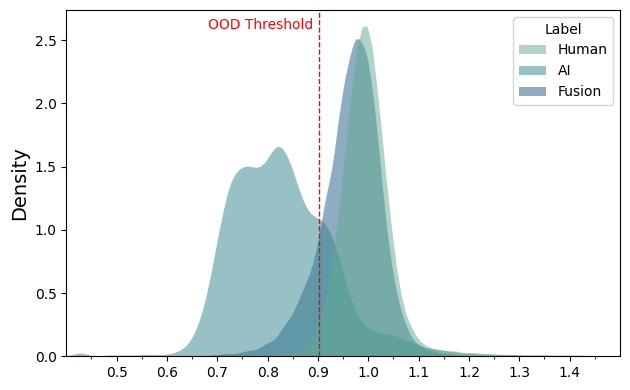

In [ ]:
fig = plt.figure(figsize=(6.4, 4))
ax = plt.gca()

plot = sns.kdeplot(
    data=plot_df,
    x="y_score",
    hue="label",
    fill=True,
    common_norm=True,
    legend=True,
    palette="crest",
    alpha=0.5,
    linewidth=0,
    ax=ax,
)

plot.set_xlim(0.4, 1.5)
plot.set_xticks(np.arange(0.5, 1.5, 0.1), minor=False)
plot.set_xticks(np.arange(0.45, 1.5, 0.05), minor=True)
plot.set_ylabel("Density", fontdict={"size": 14})
plot.set_xlabel(
    None,
    # "Binoculars Score", fontdict={"size": 14},
)

legend = ax.get_legend()
legend.set_title("Label")
# sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))

ymin, ymax = plot.get_ylim()
ax.vlines(
    [GLOBAL_BINOCULARS_THRESHOLD],
    ymin=ymin,
    ymax=ymax,
    colors="red",
    linestyles="--",
    linewidth=1,
)
ax.annotate(
    "OOD Threshold",
    (GLOBAL_BINOCULARS_THRESHOLD - 0.22, ymax - 0.15),
    color="red",
)

ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.savefig("../figures/binoculars-score_distribution-all_domains_and_agents.pgf")
plt.show()

## Without Fusion

In [61]:
df = run_ghostwriter_eval(dataframes, binarize_fusion=binarize_drop_fusion)
df

Models:   0%|          | 0/8 [00:00<?, ?model/s]

,model,corpus,agent,domain,n_samples,f1_score,precision,recall,accuracy,roc_auc,...,roc_auc_fpr,fpr_fpr,tpr_fpr,tnr_fpr,fnr_fpr,f1_human_fpr,f1_ai_fpr,threshold_fpr,n_samples_human,n_samples_ai
0,fast_detectgpt-gpt-neo-2,test,gpt-4-turbo,all,29897,0.050871,0.996700,0.029401,0.029401,0.853570,...,0.853570,0.050406,0.282828,0.949594,0.717172,0.972956,0.034377,0.999430,29798,99
1,fast_detectgpt-gpt-neo-2,test,nemotron,all,30358,0.050588,0.910671,0.042131,0.042131,0.514112,...,0.514112,0.050406,0.076786,0.949594,0.923214,0.965553,0.040855,0.999430,29798,560
2,fast_detectgpt-gpt-neo-2,test,phi3:3.8b,all,31200,0.050121,0.543393,0.050897,0.050897,0.114379,...,0.114379,0.050406,0.000000,0.949594,1.000000,0.951190,0.000000,0.999430,29798,1402
3,fast_detectgpt-gpt-neo-2,test,o3-mini,all,30057,0.050706,0.978907,0.034235,0.034235,0.582254,...,0.582254,0.050406,0.057915,0.949594,0.942085,0.970071,0.016892,0.999430,29798,259
4,fast_detectgpt-gpt-neo-2,test,deepseek-r1:32b,all,30124,0.050696,0.985507,0.036615,0.036615,0.753527,...,0.753527,0.050406,0.205521,0.949594,0.794479,0.969822,0.070712,0.999430,29798,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,detectllm_llr-falcon-7b,test,all,bundestag,8738,0.418155,0.329002,0.573587,0.573587,0.914901,...,0.914901,0.049651,0.756185,0.950349,0.243815,0.834256,0.843441,0.883393,3726,5012
132,detectllm_llr-falcon-7b,test,all,euro_court_cases,4640,0.457108,0.367017,0.605819,0.605819,0.691270,...,0.691270,0.049754,0.264674,0.950246,0.735326,0.616968,0.408118,0.908579,1829,2811
133,detectllm_llr-falcon-7b,test,all,cnn_news,9258,0.440839,0.351010,0.592461,0.592461,0.882894,...,0.882894,0.050093,0.662534,0.949907,0.337466,0.778454,0.780834,0.903587,3773,5485
134,detectllm_llr-falcon-7b,test,all,arxiv_papers,4741,0.520508,0.431140,0.656613,0.656613,0.923294,...,0.923294,0.049754,0.812078,0.950246,0.187922,0.822872,0.883607,0.895791,1628,3113


In [62]:
# %%script echo "Skipping"

df.to_csv(preds_path / "GhostWriter_test-baselines-without_fusion.csv", index=False)
df.to_csv(
    Path("/resources/public/stoeckel/PrismAI")
    / "GhostWriter_test-baselines-without_fusion.csv",
    index=False,
)

In [63]:
df_subset_agent = df[(df["agent"] != "all")].copy()
df_subset_domain = df[(df["domain"] != "all")].copy()

### By Domain

In [64]:
threshold_method = "_mean"

# df_fdg_j6B_neo27 = get_figure_df_domain(df_subset_domain, "fast_detectgpt-gpt-j-6B_gpt-neo-2", threshold_method)
# df_fdg_falcon_7b = get_figure_df_domain(df_subset_domain, "fast_detectgpt-falcon-7b", threshold_method)

df_dllm = get_figure_df_domain(
    df_subset_domain,
    "detectllm_llr-falcon-7b",
    threshold_method,
)
df_fdg = get_figure_df_domain(
    df_subset_domain,
    "fast_detectgpt-falcon-7b_falcon-7b-instruct",
    threshold_method,
)
df_binoculars = get_figure_df_domain(
    df_subset_domain,
    "binoculars-falcon-7b",
    # threshold_method,
)

df_figure_likelihood = pd.concat(
    map(
        postprocess_df_domain,
        [df_dllm, df_fdg, df_binoculars],
    ),
    axis=1,
)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc & tpr & fpr \\
domain &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.865 & 0.923 & 0.853 & 0.088 & 0.934 & 0.990 & 0.984 & 0.136 & 0.964 & 0.991 & 0.952 & 0.004 \\
Blogs & 0.605 & 0.668 & 0.632 & 0.421 & 0.660 & 0.720 & 0.649 & 0.325 & 0.665 & 0.717 & 0.447 & 0.049 \\
Bundestag & 0.854 & 0.915 & 0.805 & 0.078 & 0.872 & 0.949 & 0.911 & 0.172 & 0.689 & 0.947 & 0.473 & 0.004 \\
CNN & 0.818 & 0.883 & 0.801 & 0.151 & 0.893 & 0.968 & 0.964 & 0.195 & 0.965 & 0.970 & 0.952 & 0.014 \\
ECHR & 0.646 & 0.691 & 0.672 & 0.371 & 0.820 & 0.935 & 0.923 & 0.301 & 0.888 & 0.945 & 0.887 & 0.102 \\
Gutenberg & 0.778 & 0.899 & 0.836 & 0.176 & 0.919 & 0.988 & 0.981 & 0.174 & 0.929 & 0.991 & 0.944 & 0.023 \\
HoC & 0.771 & 0.824 & 0.778 & 0.222 & 0.897 & 0.964 & 0.942 & 0.156 & 0.937 & 0.964 & 0.908 & 0.013 \\
Spiegel & 0.803 & 0.885 & 0.785 & 

In [65]:
df_radar = get_figure_df_domain(df_subset_domain, "radar")
df_e5_lora = get_figure_df_domain(df_subset_domain, "e5_lora")

df_figure_pretrained = pd.concat(
    map(postprocess_df_domain, [df_radar, df_e5_lora]), axis=1
)
print(df_figure_pretrained.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrrrrr}
\toprule
 & f1_macro & roc_auc & tpr & fpr & f1_macro & roc_auc & tpr & fpr \\
domain &  &  &  &  &  &  &  &  \\
\midrule
arXiv & 0.405 & 0.839 & 0.150 & 0.004 & 0.570 & 0.965 & 0.994 & 0.809 \\
Blogs & 0.508 & 0.499 & 0.588 & 0.571 & 0.659 & 0.803 & 0.918 & 0.578 \\
Bundestag & 0.334 & 0.395 & 0.044 & 0.052 & 0.381 & 0.339 & 0.724 & 0.886 \\
CNN & 0.606 & 0.942 & 0.370 & 0.019 & 0.647 & 0.968 & 0.997 & 0.679 \\
ECHR & 0.620 & 0.661 & 0.574 & 0.306 & 0.406 & 0.877 & 0.993 & 0.971 \\
Gutenberg & 0.357 & 0.753 & 0.215 & 0.084 & 0.880 & 0.969 & 0.937 & 0.149 \\
HoC & 0.624 & 0.773 & 0.504 & 0.188 & 0.838 & 0.990 & 0.999 & 0.360 \\
Spiegel & 0.294 & 0.670 & 0.022 & 0.007 & 0.511 & 0.632 & 0.346 & 0.200 \\
Essays & 0.602 & 0.754 & 0.405 & 0.123 & 0.540 & 0.846 & 0.996 & 0.807 \\
Overall & 0.483 & 0.698 & 0.319 & 0.150 & 0.604 & 0.821 & 0.878 & 0.604 \\
\bottomrule
\end{tabular}



In [66]:
df_all_no_fusion = pd.concat(
    map(
        postprocess_df_domain,
        [df_dllm, df_fdg, df_binoculars, df_radar, df_e5_lora],
    ),
    axis=1,
).drop(columns=["roc_auc", "tpr", "fpr", "roc_auc_mean", "tpr_mean", "fpr_mean"])
print(df_all_no_fusion.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrr}
\toprule
 & f1_macro & f1_macro & f1_macro & f1_macro & f1_macro \\
domain &  &  &  &  &  \\
\midrule
arXiv & 0.865 & 0.934 & 0.964 & 0.405 & 0.570 \\
Blogs & 0.605 & 0.660 & 0.665 & 0.508 & 0.659 \\
Bundestag & 0.854 & 0.872 & 0.689 & 0.334 & 0.381 \\
CNN & 0.818 & 0.893 & 0.965 & 0.606 & 0.647 \\
ECHR & 0.646 & 0.820 & 0.888 & 0.620 & 0.406 \\
Gutenberg & 0.778 & 0.919 & 0.929 & 0.357 & 0.880 \\
HoC & 0.771 & 0.897 & 0.937 & 0.624 & 0.838 \\
Spiegel & 0.803 & 0.835 & 0.698 & 0.294 & 0.511 \\
Essays & 0.876 & 0.902 & 0.972 & 0.602 & 0.540 \\
Overall & 0.780 & 0.859 & 0.856 & 0.483 & 0.604 \\
\bottomrule
\end{tabular}



### By Agent

In [69]:
# df_fdg_j6B_neo27 = get_figure_df_agent(df_subset_agent, "fast_detectgpt-gpt-j-6B_gpt-neo-2", threshold_method)
# df_fdg_falcon_7b = get_figure_df_agent(df_subset_agent, "fast_detectgpt-falcon-7b", threshold_method)

df_dllm = get_figure_df_agent(
    df_subset_agent,
    "detectllm_llr-falcon-7b",
    threshold_method,
)
df_fdg = get_figure_df_agent(
    df_subset_agent,
    "fast_detectgpt-falcon-7b_falcon-7b-instruct",
    threshold_method,
)
df_binoculars = get_figure_df_agent(
    df_subset_agent,
    "binoculars-falcon-7b",
    # threshold_method,
)

df_figure_likelihood = pd.concat(
    map(
        postprocess_df_agent,
        [df_dllm, df_fdg, df_binoculars],
    ),
    axis=1,
)
print(df_figure_likelihood.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc_mean & tpr_mean & fpr_mean & f1_macro & roc_auc & tpr & fpr \\
agent &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
deepseek-r1:1.5b & 0.260 & 0.268 & 0.340 & 0.660 & 0.445 & 0.815 & 0.782 & 0.313 & 0.630 & 0.810 & 0.370 & 0.022 \\
deepseek-r1:32b & 0.402 & 0.722 & 0.656 & 0.374 & 0.474 & 0.922 & 0.890 & 0.228 & 0.681 & 0.915 & 0.690 & 0.022 \\
gemma2:9b & 0.667 & 0.754 & 0.702 & 0.354 & 0.833 & 0.937 & 0.908 & 0.220 & 0.853 & 0.933 & 0.706 & 0.022 \\
gpt-4-turbo & 0.412 & 0.814 & 0.768 & 0.321 & 0.465 & 0.986 & 0.980 & 0.187 & 0.594 & 0.982 & 0.838 & 0.022 \\
gpt-4o-mini & 0.810 & 0.900 & 0.833 & 0.195 & 0.880 & 0.985 & 0.974 & 0.175 & 0.967 & 0.986 & 0.953 & 0.022 \\
nemotron & 0.294 & 0.414 & 0.530 & 0.610 & 0.441 & 0.788 & 0.748 & 0.326 & 0.660 & 0.799 & 0.436 & 0.022 \\
o3-mini & 0.327 & 0.499 & 0.548 & 0.531 & 0.428 & 0.819 & 0.780 & 0.312 & 0.579 & 0.803 & 0.332 & 0.022

In [70]:
df_radar = get_figure_df_agent(df_subset_agent, "radar")
df_e5_lora = get_figure_df_agent(df_subset_agent, "e5_lora")

df_figure_pretrained = pd.concat(
    map(postprocess_df_agent, [df_radar, df_e5_lora]), axis=1
)
print(df_figure_pretrained.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{lrrrrrrrr}
\toprule
 & f1_macro & roc_auc & tpr & fpr & f1_macro & roc_auc & tpr & fpr \\
agent &  &  &  &  &  &  &  &  \\
\midrule
deepseek-r1:1.5b & 0.519 & 0.855 & 0.704 & 0.159 & 0.275 & 0.893 & 0.966 & 0.663 \\
deepseek-r1:32b & 0.475 & 0.634 & 0.319 & 0.159 & 0.265 & 0.775 & 0.868 & 0.663 \\
gemma2:9b & 0.523 & 0.609 & 0.250 & 0.159 & 0.541 & 0.743 & 0.851 & 0.663 \\
gpt-4-turbo & 0.459 & 0.553 & 0.131 & 0.159 & 0.256 & 0.739 & 0.798 & 0.663 \\
gpt-4o-mini & 0.623 & 0.693 & 0.403 & 0.159 & 0.540 & 0.800 & 0.888 & 0.663 \\
nemotron & 0.495 & 0.710 & 0.405 & 0.159 & 0.276 & 0.703 & 0.904 & 0.663 \\
o3-mini & 0.467 & 0.588 & 0.228 & 0.159 & 0.263 & 0.731 & 0.861 & 0.663 \\
phi3:3.8b & 0.505 & 0.552 & 0.262 & 0.159 & 0.306 & 0.717 & 0.886 & 0.663 \\
Overall & 0.508 & 0.649 & 0.338 & 0.159 & 0.340 & 0.763 & 0.878 & 0.663 \\
\bottomrule
\end{tabular}

